### Abstract

The objective is to choose the best model for a given data, thus we need to make several models  with a portion of the data and evaluating the best model possible by choosing the one with the lowest SSE. After choosing the best model is necessary to create a new model with all training data avaiable in order to create outputs for the real data.

# Import Libraries

In [11]:
import numpy as np
import random
from matplotlib import pyplot as plt
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures,  StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, RepeatedKFold, GridSearchCV

# Import Train Data

In [12]:
X_import = np.load("data/Xtrain_Regression1.npy")
Y_import = np.load("data/Ytrain_Regression1.npy")
# create global functions to store the splitted data
X_train,Y_train,X_test,Y_test = 0,0,0,0

# Essencial Functions

In [13]:
def split_data(x_import,y_import,test_siz):
    '''Splits the data according to the test_siz fraction'''
    x_train, x_test, y_train, y_test = train_test_split(x_import, y_import, test_size=test_siz)
    return (x_train,y_train,x_test,y_test)

def refresh_data(div):
    '''Refreshes the data split'''
    global X_train,Y_train,X_test,Y_test
    (X_train,Y_train,X_test,Y_test) = split_data(X_import,Y_import,div)

def calc_SSE(y_pred,y):
    '''Calculates the SSE from the predicted data'''
    #return np.sum((y_pred - y)**2)
    return mean_squared_error(y_pred,y)*np.shape(y)[0]

def beta_from_model(model):
    '''Returns the complete beta matrix from the model'''
    beta = model.coef_[0]
    beta[0] = model.intercept_[0]
    return beta 

# Linear Model

In [14]:
def linear_model(x, y):
    '''Creates and returns a simple linear regression model of order 1'''
    LR = LinearRegression()
    LR.fit(x,y)
    return LR

def test_linear_model(x_train,y_train,x_test,y_test,iters):
    '''Tests the linear model returning a simple SSE value'''

    SSE_lst = []

    for i in range(iters):
        refresh_data(0.2)
        model_sl = linear_model(X_train, Y_train)
        y_pred = model_sl.predict(X_test)
        SSE_lst.append(calc_SSE(y_pred, Y_test))

    SSE_avg = np.mean(SSE_lst)
    SSE_std = np.std(SSE_lst)

    return(SSE_avg,SSE_std)

SSE_lin = test_linear_model(X_train,Y_train,X_test,Y_test,500)
print("Average SSE :", SSE_lin[0], "+/-", SSE_lin[1])

Average SSE : 0.25393623971147694 +/- 0.06926907111383145


# Polynomial Model

SSE order 1 : 0.255790218697859 +/- 0.0693412129497014
SSE order 2 : 12.407833016255422 +/- 35.41694684225008
SSE order 3 : 30.838917581384955 +/- 12.181430121923201
SSE order 4 : 81.81271415462714 +/- 37.32763622089003


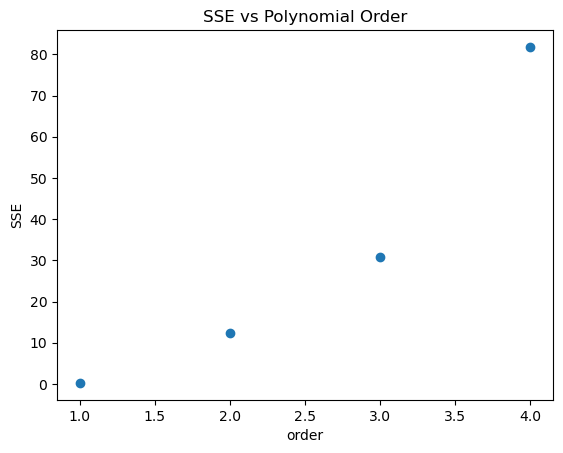

In [15]:
def polynomial_model(x, y, deg):
    '''Creates the polynomial model'''

    poly = PolynomialFeatures(degree=deg, include_bias=True)  
    poly_features = poly.fit_transform(x)  
    poly_reg_model = LinearRegression()  
    poly_reg_model.fit(poly_features, y)
    return poly_reg_model, poly

def test_polynomial_model(deg_max,iters,show_plots=True):
    '''Tests the polynomial model up to deg_max'''

    order_list, SSE, SSE_plt = [i for i in range(1,deg_max+1)], [], []

    def get_avg_sse(i):
        '''Returns the average SSE for a given polynomial degree'''
        SSE_lst = []
        for s in range(1,iters):
            refresh_data(0.2)
            (model,poly) = polynomial_model(X_train,Y_train,i)
            x_test_trans = poly.transform(X_test)
            y_pred = model.predict(x_test_trans)
            SSE_lst.append(calc_SSE(y_pred,Y_test))
        return [np.mean(SSE_lst), np.std(SSE_lst)]
        

    for i in range(1,deg_max+1):
        SSE.append(get_avg_sse(i))
        SSE_plt.append(SSE[-1][0])
    
    
    if show_plots:
        plt.scatter(order_list, SSE_plt)
        plt.xlabel('order')
        plt.ylabel('SSE')
        plt.title('SSE vs Polynomial Order')
        
        return SSE, plt
    
    else:
        return SSE


SSE_pol, plot_pol = test_polynomial_model(4,500,show_plots=True)
for i in range(len(SSE_pol)):
    print("SSE order",i+1,":",SSE_pol[i][0], "+/-", SSE_pol[i][1])
plot_pol.show()

# Ridge Model

In [16]:
def ridge_modelcv(x,y,cv):
    param = {
    # Uncoment just on list of alphas at a time and fine tune
    #'alpha':[0.0001, 0.001,0.01,1], #First Run select order -> 0.001 the best
    'alpha':(np.logspace(-3, 0, 100)), #At this range is random  -8,8
    'fit_intercept':[True,False],
    'solver':['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'] #,'lbfgs'
    }
    
    model = Ridge()
    search = GridSearchCV(model, param, scoring='r2', n_jobs=-1, cv=cv)
    result = search.fit(x, y)
    return result

def test_ridge_model(pt=True):
    '''This function tests the ridge model'''
    global X_train, X_test, Y_train, Y_test

    X_sc = StandardScaler().fit_transform(X_import)
    X_train, X_test, Y_train, Y_test = train_test_split(X_sc, Y_import, test_size=0.2)
    cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1)

    model = ridge_modelcv(X_train,Y_train,cv)
    y_pred = model.predict(X_test)
    r2=model.best_score_
    sse=calc_SSE(y_pred,Y_test)
    mse=mean_squared_error(Y_test,y_pred)
    alpha=model.best_params_['alpha']

    if pt==True:
        print('R2: %s' % r2)
        print('SSE:',sse)
        print('MSE',mse)
        print('Best Hyperparameters: %s' % model.best_params_)
    return r2, sse, mse, alpha

test_ridge_model()

R2: 0.9966629045185684
SSE: 0.25709429284292207
MSE 0.012854714642146103
Best Hyperparameters: {'alpha': 0.004641588833612782, 'fit_intercept': True, 'solver': 'saga'}


(0.9966629045185684,
 0.25709429284292207,
 0.012854714642146103,
 0.004641588833612782)

In [17]:
#Test for 1000 runs average -> change False to True
if False:
    r2,mse = [], []
    for i in range(1000):
        X_sc = StandardScaler().fit_transform(X_import)
        X_train, X_test, Y_train, Y_test = train_test_split(X_sc, Y_import, test_size=0.2)
        ridge_model = Ridge(alpha = 1.35 * 10**(-8) ,fit_intercept = True, solver = 'saga')
        model = ridge_model.fit(X_train,Y_train)
        y_pred = model.predict(X_test)
        r2.append(r2_score(Y_test,y_pred))
        mse.append(mean_squared_error(Y_test,y_pred))
    print("Average R2:", np.mean(r2),"+/",np.std(r2))
    print("Average MSE:", np.mean(mse),"+/",np.std(mse))

# Lasso Model

In [21]:
def lasso_modelcv(x,y,cv):
    param = {
    # Uncoment just on list of alphas at a time and fine tune
    #'alpha':[0.0001, 0.001,0.01,1], #First Run select order -> 0.001 the best
    'alpha':(np.logspace(-3, 0, 100)), #At this range is random -8,8
    'fit_intercept':[True,False]
       }
    
    lasso = Lasso()
    search = GridSearchCV(lasso, param, scoring='r2' ,cv=cv)
    result = search.fit(x, y)
    return result

def test_lasso_model(pt=True):
    '''This function tests the ridge model'''
    global X_train, X_test, Y_train, Y_test

    X_sc = StandardScaler().fit_transform(X_import)
    X_train, X_test, Y_train, Y_test = train_test_split(X_sc, Y_import, test_size=0.2)
    cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1)

    model = lasso_modelcv(X_train,Y_train,cv)
    y_pred = model.predict(X_test)
    r2=model.best_score_
    sse=calc_SSE(y_pred,Y_test)
    mse=mean_squared_error(Y_test,y_pred)
    alpha=model.best_params_['alpha']

    if pt==True:
        print('R2: %s' % r2)
        print('SSE:',sse)
        print('MSE',mse)
        print('Best Hyperparameters: %s' % model.best_params_)
    return r2, sse, mse, alpha

test_lasso_model()

R2: 0.9964247508918718
SSE: 0.19113013117937427
MSE 0.009556506558968714
Best Hyperparameters: {'alpha': 0.006135907273413176, 'fit_intercept': True}


(0.9964247508918718,
 0.19113013117937427,
 0.009556506558968714,
 0.006135907273413176)

In [19]:
#Test for 1000 runs average -> change False to True
if True:
    r2,mse = [], []
    for i in range(1000):
        X_sc = StandardScaler().fit_transform(X_import)
        X_train, X_test, Y_train, Y_test = train_test_split(X_sc, Y_import, test_size=0.2)
        lasso_model = Lasso(alpha = 0.0007054802310718645 ,fit_intercept = True)
        model = lasso_model.fit(X_train,Y_train)
        y_pred = model.predict(X_test)
        r2.append(r2_score(Y_test,y_pred))
        mse.append(mean_squared_error(Y_test,y_pred))
    print("Average R2:", np.mean(r2),"+/",np.std(r2))
    print("Average MSE:", np.mean(mse),"+/",np.std(mse))

Average R2: 0.9977065855452991 +/ 0.0009975102325299196
Average MSE: 0.012608650176187708 +/ 0.0035424291411176928


## Conclusions

Let's assume Ridge is the best model due to a marginal difference in SSE

In [20]:
x_eval_import = np.load("data/Xtest_Regression1.npy")
model = ridge_model(X_import,Y_import,0.25)
y_pred = model.predict(x_eval_import)
y_pred

NameError: name 'ridge_model' is not defined

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=25889058-66de-44c8-ad64-ee695f6c1052' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>